# COMP9517 Group Project

### Data Exploration & Analysis

First we will do some preliminary data exploration to understand what is contained in this dataset. Since this is a novel dataset, there is no guarantee that the data is complete, or that every single photo contains at least one head, carapace, and fin. 

In [8]:
from pycocotools.coco import COCO

# Load in annotations file
annotation_file = 'turtles-data/data/annotations.json'
coco = COCO(annotation_file)
print("\n----------------- Dataset Information -----------------\n")

# Count number of images for our dataset
image_ids = coco.getImgIds()
num_images = len(image_ids)
print("Number of images in dataset: ", num_images)

# Identify the number of categories in our dataset
coco.loadCats(coco.getCatIds())
category_ids = coco.loadCats(coco.getCatIds())
categories = {category['id']: category['name'] for category in category_ids}

# Ensure there are no additonal categories that we did not expect
expected_categories = {'turtle', 'head', 'flipper'}
if set(categories.values()) != expected_categories:
    raise ValueError(f"Unexpected categories in dataset {categories}")
else:
    print("\nAll categories are expected in dataset")

loading annotations into memory...
Done (t=3.66s)
creating index...
index created!

----------------- Dataset Information -----------------

Number of images in dataset:  8729

All categories are expected in dataset


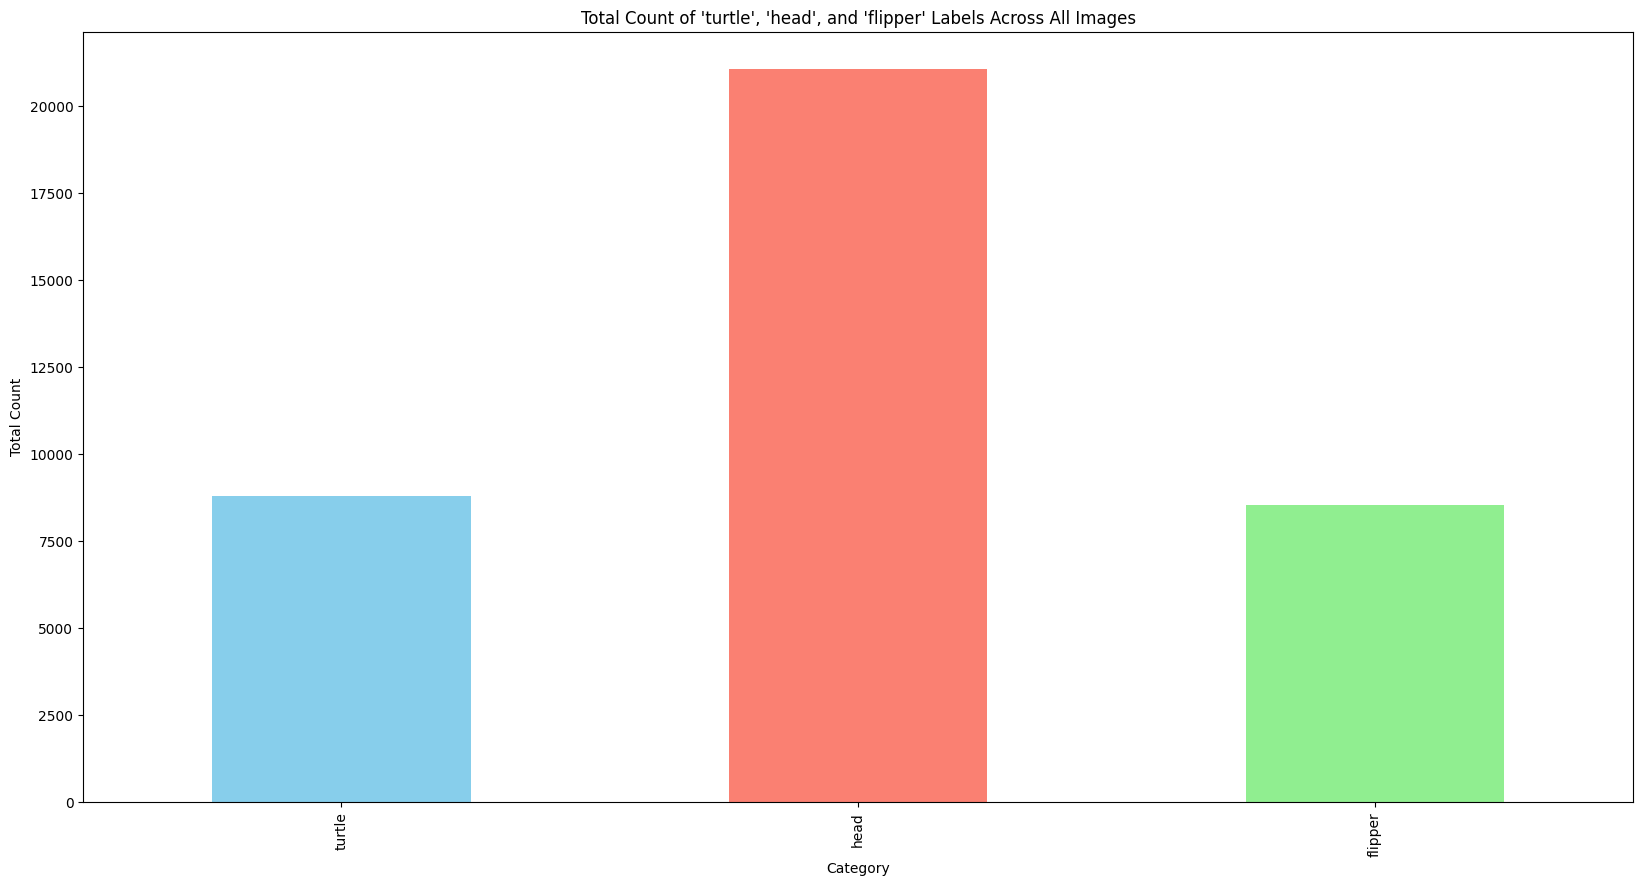

c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
c:\Users\Sun\AppData\Local\Programs\Python\Python311\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is de

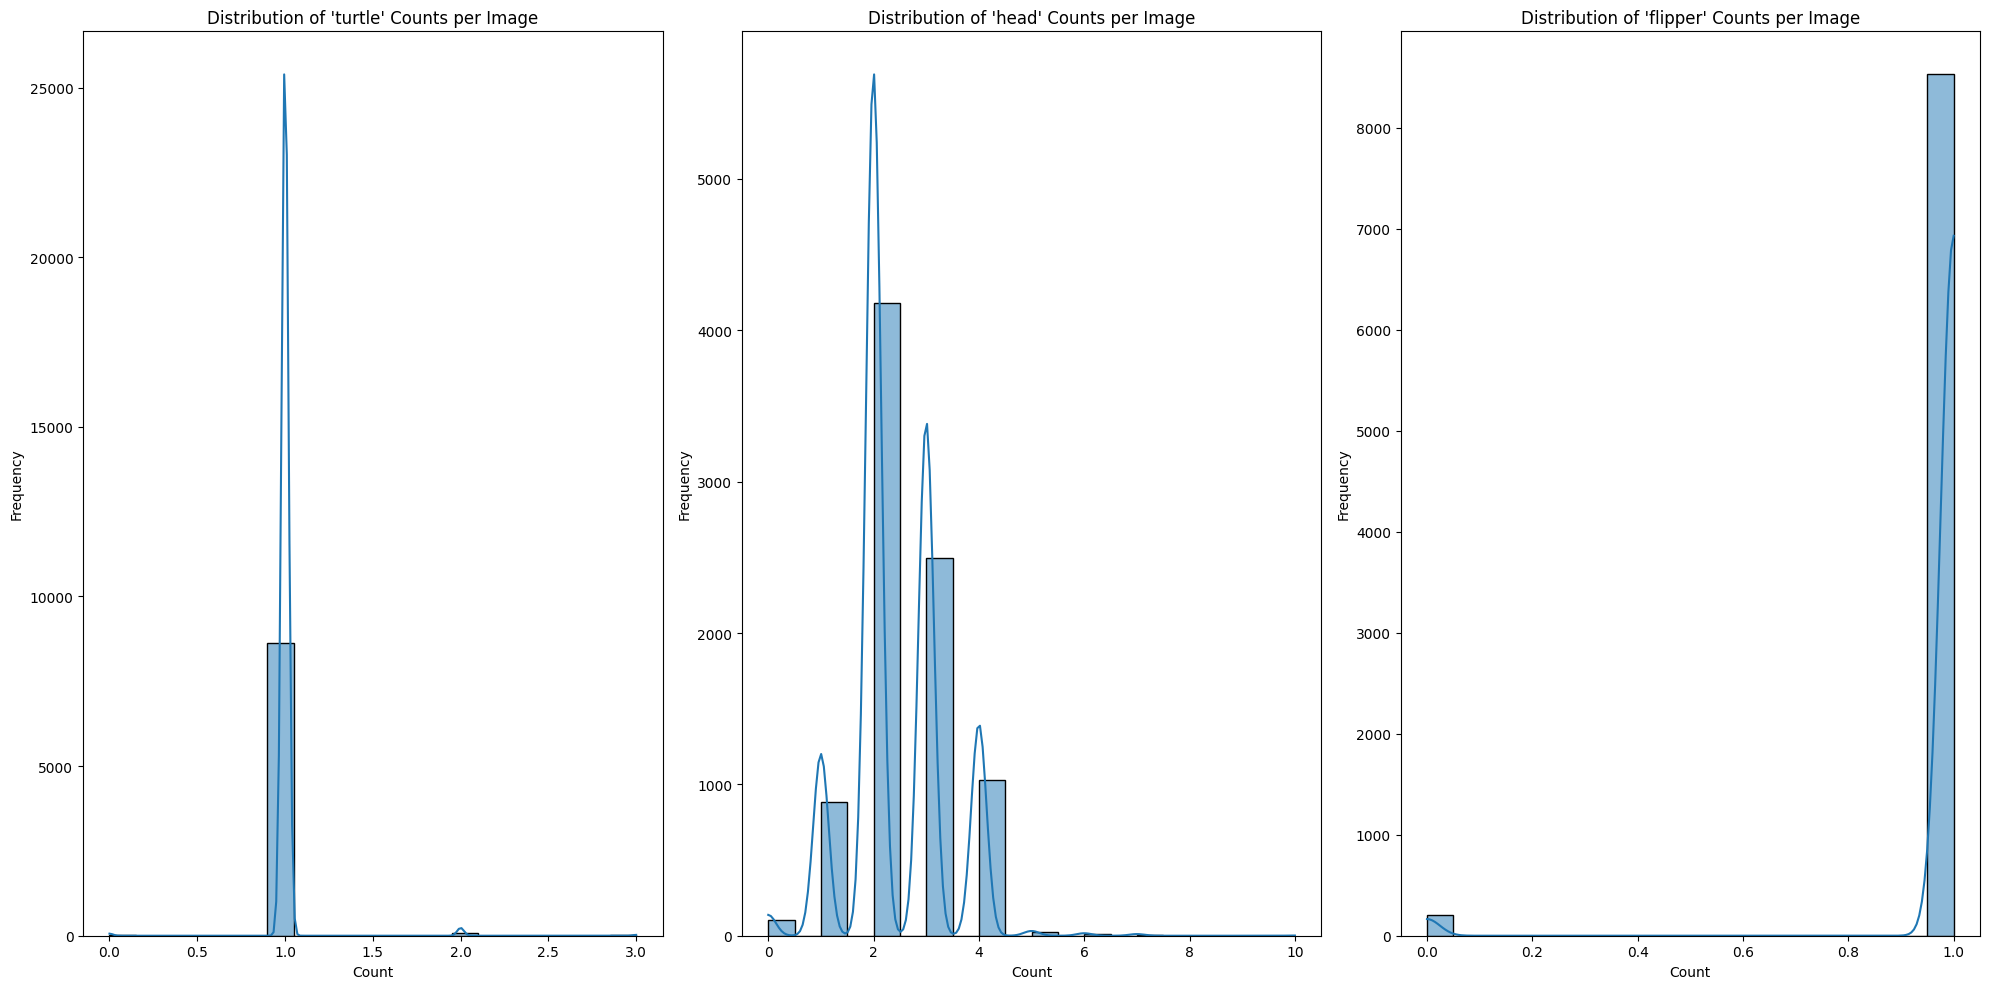

In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


category_names = ["turtle", "head", "flipper"]
cat_ids = coco.getCatIds(catNms=category_names)

# Create a dictionary to count how many counts of each category there are in each image
category_counts = {'image_id': [], 'turtle': [], 'head': [], 'flipper': []}

# Loop over each image
img_ids = coco.getImgIds()
for img_id in img_ids:
    ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_ids)
    anns = coco.loadAnns(ann_ids)

    # Append the current image ID
    category_counts["image_id"].append(img_id)

    # Count number of each category for current image ID
    category_counts["turtle"].append(
        sum(ann["category_id"] == cat_ids[0] for ann in anns)
    )
    category_counts["head"].append(
        sum(ann["category_id"] == cat_ids[1] for ann in anns)
    )
    category_counts["flipper"].append(
        sum(ann["category_id"] == cat_ids[2] for ann in anns)
    )

# Convert to dataframe
category_counts_df = pd.DataFrame(category_counts)
category_sums = category_counts_df[["turtle", "head", "flipper"]].sum()

# Totals for each category
plt.figure(figsize=(20, 10))
category_sums.plot(kind="bar", color=["skyblue", "salmon", "lightgreen"])
plt.title("Total Count of 'turtle', 'head', and 'flipper' Labels Across All Images")
plt.xlabel("Category")
plt.ylabel("Total Count")
plt.show()

plt.figure(figsize=(20, 10))
for i, category in enumerate(["turtle", "head", "flipper"]):
    plt.subplot(1, 3, i + 1)
    sns.histplot(category_counts_df[category], kde=True, bins=20)
    plt.title(f"Distribution of '{category}' Counts per Image")
    plt.xlabel("Count")
    plt.ylabel("Frequency")
plt.tight_layout()
plt.show()

Dataset contains 8729 images. Some images may not contain a turtle, head, or flipper so we will investigate these files manually.

In [15]:
required_categories = ["turtle", "head", "flipper"]
cat_ids = coco.getCatIds(catNms=required_categories)
cat_ids_map = dict(zip(category_names, cat_ids))

missing_labels_images = {category: 0 for category in required_categories}
img_ids = coco.getImgIds()

for img_id in img_ids:
    for category, cat_id in cat_ids_map.items():
        ann_ids = coco.getAnnIds(imgIds=img_id, catIds=cat_id)
        if not ann_ids:
            missing_labels_images[category] += 1
            break

for category, count in missing_labels_images.items():
    print(f"\nNumber of images missing '{category}' label: {count}")



Number of images missing 'turtle' label: 20

Number of images missing 'head' label: 84

Number of images missing 'flipper' label: 174
